In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def showImg(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

CONFIGURATION = {
    "IM_SIZE": 256,
    "PATCH_SIZE": 16,
    "N_CLASSES":3,
    'BATCH_SIZE': 32,
}

2024-10-10 04:26:41.774054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 04:26:42.229625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 04:26:42.298201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 04:26:42.916235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

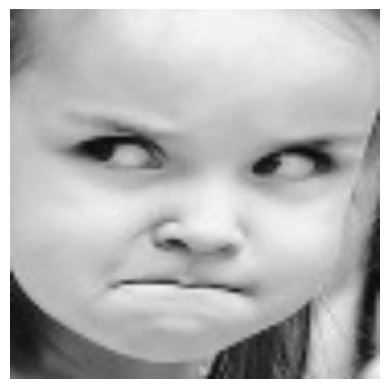

In [2]:
image = cv2.imread('../EmotionsDataset/test/angry/2585.jpg')
image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
showImg(image)

In [3]:
print(image.shape)
print(tf.expand_dims(image,axis=0).shape)

(256, 256, 3)
(1, 256, 256, 3)


I0000 00:00:1727456015.954967    1162 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727456016.157142    1162 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727456016.157235    1162 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727456016.195375    1162 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727456016.195474    1162 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
# Extract patches
patches = tf.image.extract_patches(
    images=tf.expand_dims(image,axis=0),
    sizes=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
    strides=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)
patches=tf.reshape(patches,(patches.shape[0],-1,768))
print(patches.shape)

(1, 256, 768)


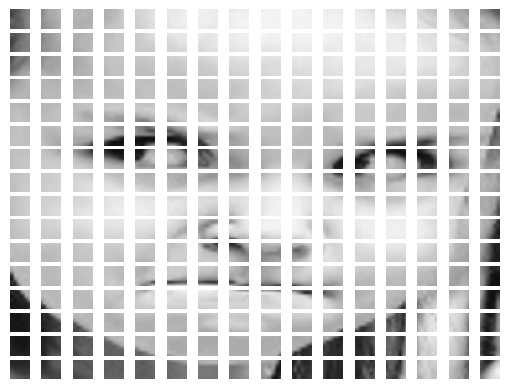

In [5]:
for i in range(patches.shape[1]):
    ax = plt.subplot(16, 16, i + 1)
    # Get the patch and check its shape
    patch = patches[0, i, :].numpy()  # Convert to numpy for reshaping
    plt.imshow(patch.reshape((16, 16, 3)))
    plt.axis('off')

plt.show()

In [6]:
from tensorflow.keras.layers import Layer,Dense,Embedding,MultiHeadAttention,LayerNormalization,Add
class PatchEncoder(Layer):
    def __init__(self,N_PATCHES,HIDDEN_SIZE):
        super(PatchEncoder,self).__init__()
        self.linear_projection = Dense(HIDDEN_SIZE)
        self.positional_embeding = Embedding(
            N_PATCHES,
            HIDDEN_SIZE,
        )
        self.N_PATCHES = N_PATCHES
    def call(self,x):
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
            strides=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches=tf.reshape(patches,(tf.shape(patches)[0],-1,patches.shape[-1]))
        embedding_vector = tf.range(start = 0 , limit = self.N_PATCHES, delta=1)
        output = self.linear_projection(patches) + self.positional_embeding(embedding_vector)
        return output

In [7]:
pe = PatchEncoder(256, 768)
output = pe(tf.zeros([5, 256, 256, 3]))  # Passing a tensor with correct shape
print(output.shape)

(5, 256, 768)


In [8]:
class TransformerEncoder(Layer):
    def __init__(self,N_HEADS,HIDDEN_SIZE):
        super(TransformerEncoder,self).__init__(name="transformer_encoder")
        self.layer_norm_1 = LayerNormalization()
        self.layer_norm_2 = LayerNormalization()
        self.multi_headed_attention = MultiHeadAttention(N_HEADS,HIDDEN_SIZE)
        self.mlp_1 = Dense(HIDDEN_SIZE,activation = tf.nn.gelu)
        self.mlp_2 = Dense(HIDDEN_SIZE,activation = tf.nn.gelu)

    def call(self, Input):
        # Apply layer normalization and multi-headed attention
        x_1 = self.layer_norm_1(Input)
        x_1 = self.multi_headed_attention(x_1, x_1)
        x_1 = Add()([x_1, Input])

        # Apply the second layer normalization and MLP layers
        x_2 = self.layer_norm_2(x_1)
        x_2 = self.mlp_1(x_2)
        x_2 = self.mlp_2(x_2)

        # Add the output of MLP with the residual connection from x_1
        output = Add()([x_2, x_1])  # Now x_2 and x_1 have the same shape
        return output

In [9]:
# Example usage
te = TransformerEncoder(8, 768)
output = te(tf.zeros([3, 256, 768]))  # Input with shape (batch_size, sequence_length, hidden_size)
print(output.shape)

(3, 256, 768)


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
class ViT(Model):
    def __init__(self,N_HEADS,N_PATCHES,HIDDEN_SIZE,N_LAYERS,N_DENSE_UNITS):
        super(ViT,self).__init__(name="vitModel")
        self.N_LAYERS = N_LAYERS
        self.PatchEncoder = PatchEncoder(N_PATCHES,HIDDEN_SIZE)
        self.TransformerEncoder = [TransformerEncoder(N_HEADS,HIDDEN_SIZE) for _ in range(N_LAYERS)]
        self.dense_1 = Dense(N_DENSE_UNITS,activation=tf.nn.gelu)
        self.dense_2 = Dense(N_DENSE_UNITS,activation=tf.nn.gelu)
        self.dense_3 = Dense(CONFIGURATION['N_CLASSES'],activation=tf.nn.softmax)
        
    def call(self,input, training = True):
        x=self.PatchEncoder(input)

        for i in range(self.N_LAYERS):
            x=self.TransformerEncoder[i](x)
        x= Flatten()(x)
        x= self.dense_1(x)
        x= self.dense_2(x)
        return self.dense_3(x)

In [11]:
vit = ViT(N_HEADS=8,N_PATCHES=256,HIDDEN_SIZE=768,N_LAYERS=2,N_DENSE_UNITS=128)
vit(tf.zeros([1,256,256,3]))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.49778554, 0.27873468, 0.22347978]], dtype=float32)>

In [12]:
vit.summary()

Model: "vitModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_encoder_1 (PatchEncoder)  │ ?                      │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    20,077,824 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ ?                      │    20,077,824 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 128)               │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (1, 3)                 │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,125,699 (252.25 MB)

 Trainable params: 66,125,699 (252.25 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
vit.compile(optimizer=Adam(learning_rate=0.0001),loss=CategoricalCrossentropy(),metrics=[Accuracy()])

In [14]:
TRAIN_DIR = '../EmotionsDataset/train/'
TEST_DIR = '../EmotionsDataset/test/'
CLASS_NAMES = ['angry','happy','sad']
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [15]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, [CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']])  # Resize images to 224x224
    image = tf.cast(image, tf.float32)  # Convert images to float32
    return image, label

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Normalization function
def normalise(image, label):
    return image / 255.0, label

# Apply normalization
train_dataset = train_dataset.map(normalise)
test_dataset = test_dataset.map(normalise)

# # Apply shuffling, batching, and prefetching
train_dataset = train_dataset.shuffle(buffer_size=1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [16]:
vit.fit(train_dataset,validation_data=test_dataset,epochs=10)

Epoch 1/10


2024-09-27 16:54:39.707830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 105 of 1024
2024-09-27 16:55:17.633207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 166 of 1024
2024-09-27 16:55:30.507813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 202 of 1024
2024-09-27 16:55:33.262446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1727456141.165037    1233 service.cc:146] XLA service 0x7fd0e800a260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727456141.191254    1233 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-27 16:55:43.192944: I tensorflow/compiler/mlir/tensorflow/util

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/usr/lib/python3.11/runpy.py", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1162/2101365978.py", line 1, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 2214083656 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_11552]